# Sparse Regression with AILibs

This notebook demonstrates **sparse linear regression** using `AILibs.linear_regression.lr_sparse_fit`.

Sparse regression is useful when the true coefficient matrix $A$ has many zero entries.
The algorithm iteratively adds the most significant coefficients, producing a compact model.

We cover:
1. **1D sparse fit** — identifying the active features in a simple model
2. **Sparse vs Dense comparison** — showing when sparsity helps
3. **Sparse polynomial regression** — combining dictionary expansion with sparsity
4. **High-dimensional sparse recovery** — many features, few active
5. **Multi-output sparse regression** — coefficient matrix visualisation

In [1]:
import numpy
import matplotlib.pyplot as plt

import AILibs

rng = numpy.random.default_rng(42)

## 1. 1D Example — Identifying Active Features

Create 10 input features but only 3 are actually used in the model.

In [2]:
n_features = 10
n_samples = 500
n_active = 3

x = rng.standard_normal((n_samples, n_features))

# true coefficients: only 3 non-zero
a_true = numpy.zeros((n_features, 1))
active_idx = rng.choice(n_features, n_active, replace=False)
a_true[active_idx] = rng.standard_normal((n_active, 1)) * 2.0

y = x @ a_true + rng.normal(0, 0.1, (n_samples, 1))

print(f"Active indices: {sorted(active_idx)}")
print(f"True coefficients: {a_true.flatten()}")

# sparse fit
a_sparse = AILibs.linear_regression.lr_sparse_fit(x, y)
y_pred_sparse = x @ a_sparse


# dense fit
a_dense = AILibs.linear_regression.lr_fit(x, y)
y_pred_dense = x @ a_dense

m_sparse = AILibs.metrics.regression_evaluation(y, y_pred_sparse)
m_dense  = AILibs.metrics.regression_evaluation(y, y_pred_dense)

print(f"\nSparse R²: {m_sparse['r2']:.5f},  Dense R²: {m_dense['r2']:.5f}")
print(f"Sparse non-zeros: {numpy.count_nonzero(a_sparse)},  Dense non-zeros: {numpy.count_nonzero(a_dense)}")

Active indices: [np.int64(1), np.int64(2), np.int64(4)]
True coefficients: [ 0.          0.85696586 -3.1812994   0.          0.46929238  0.
  0.          0.          0.          0.        ]

Sparse R²: 0.99905,  Dense R²: 0.99905
Sparse non-zeros: 10,  Dense non-zeros: 10


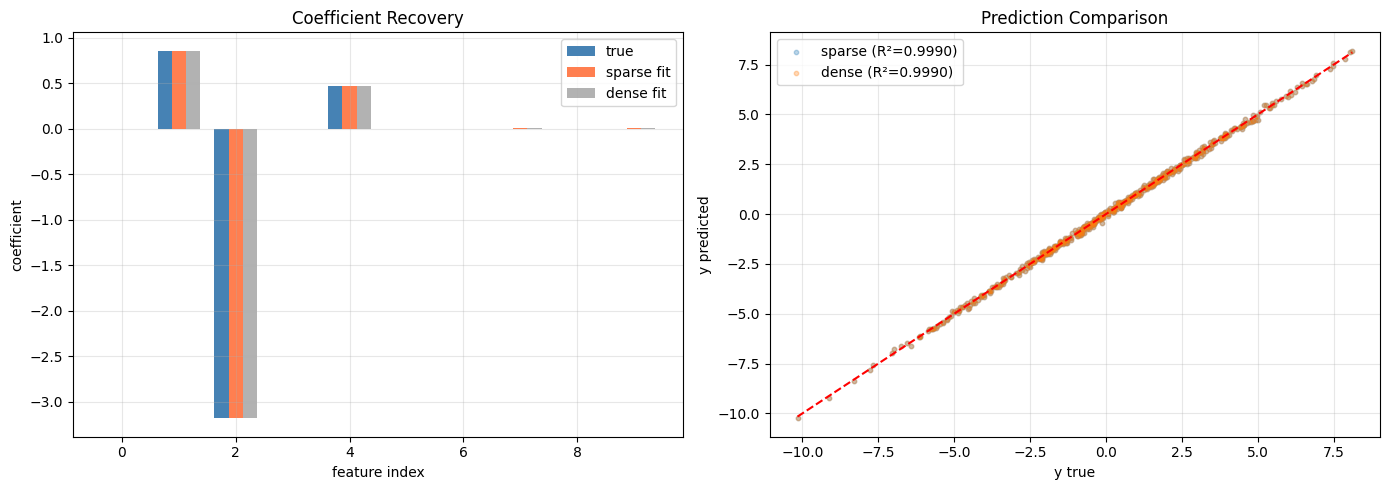

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

idx = numpy.arange(n_features)
width = 0.25

axes[0].bar(idx - width, a_true.flatten(), width, label="true", color="steelblue")
axes[0].bar(idx, a_sparse.flatten(), width, label="sparse fit", color="coral")
axes[0].bar(idx + width, a_dense.flatten(), width, label="dense fit", color="gray", alpha=0.6)
axes[0].set_xlabel("feature index")
axes[0].set_ylabel("coefficient")
axes[0].set_title("Coefficient Recovery")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].scatter(y, y_pred_sparse, alpha=0.3, s=10, label=f"sparse (R²={m_sparse['r2']:.4f})")
axes[1].scatter(y, y_pred_dense, alpha=0.3, s=10, label=f"dense (R²={m_dense['r2']:.4f})")
lims = [y.min(), y.max()]
axes[1].plot(lims, lims, "r--", linewidth=1.5)
axes[1].set_xlabel("y true")
axes[1].set_ylabel("y predicted")
axes[1].set_title("Prediction Comparison")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Sparse vs Dense — Effect of Sparsity Level

Sweep sparsity from 0% to 95% and compare coefficient recovery.

In [4]:
n_features_sw = 20
n_outputs_sw  = 5
n_samples_sw  = 800
sparsity_levels = [0.0, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95]

x_sw = rng.standard_normal((n_samples_sw, n_features_sw))

results_sparse = []
results_dense = []

for sp in sparsity_levels:
    A_sw = rng.standard_normal((n_features_sw, n_outputs_sw))
    mask = rng.random(A_sw.shape) < sp
    A_sw[mask] = 0.0
    
    Y_sw = x_sw @ A_sw + rng.normal(0, 0.1, (n_samples_sw, n_outputs_sw))
    
    A_sp = AILibs.linear_regression.lr_sparse_fit(x_sw, Y_sw)
    A_dn = AILibs.linear_regression.lr_fit(x_sw, Y_sw)
    
    err_sp = numpy.mean((A_sw - A_sp) ** 2)
    err_dn = numpy.mean((A_sw - A_dn) ** 2)
    
    results_sparse.append(err_sp)
    results_dense.append(err_dn)
    
    print(f"sparsity {sp:.0%}: sparse coeff MSE = {err_sp:.5f}, dense coeff MSE = {err_dn:.5f}")

sparsity 0%: sparse coeff MSE = 0.00001, dense coeff MSE = 0.00001
sparsity 30%: sparse coeff MSE = 0.00001, dense coeff MSE = 0.00001
sparsity 50%: sparse coeff MSE = 0.00001, dense coeff MSE = 0.00001
sparsity 70%: sparse coeff MSE = 0.00002, dense coeff MSE = 0.00002
sparsity 80%: sparse coeff MSE = 0.00001, dense coeff MSE = 0.00001
sparsity 90%: sparse coeff MSE = 0.00001, dense coeff MSE = 0.00001
sparsity 95%: sparse coeff MSE = 0.00002, dense coeff MSE = 0.00002


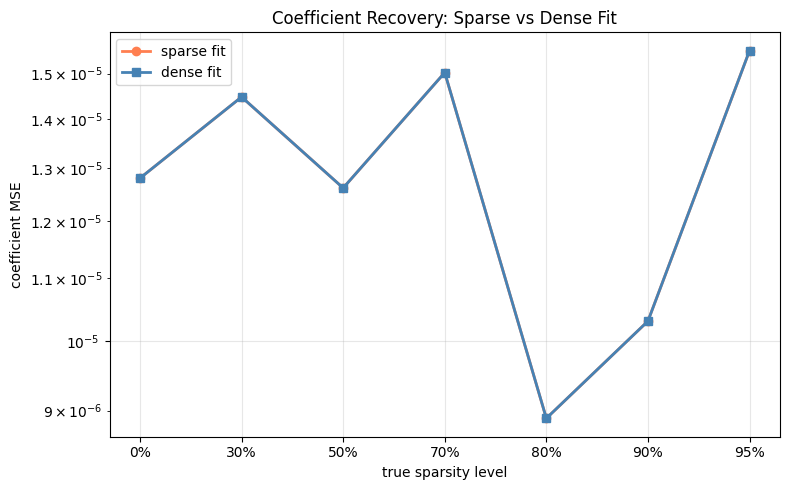

In [5]:
plt.figure(figsize=(8, 5))
plt.plot([f"{s:.0%}" for s in sparsity_levels], results_sparse, "o-", label="sparse fit", color="coral", linewidth=2)
plt.plot([f"{s:.0%}" for s in sparsity_levels], results_dense, "s-", label="dense fit", color="steelblue", linewidth=2)
plt.xlabel("true sparsity level")
plt.ylabel("coefficient MSE")
plt.title("Coefficient Recovery: Sparse vs Dense Fit")
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale("log")
plt.tight_layout()
plt.show()

## 3. Sparse Polynomial Regression

Combine `dictionary_polynomial` with sparse fitting — only a few polynomial terms are active.

In [6]:
# true function: y = 3x + 0.5x^3  (no x^2, x^4, x^5 terms)
n = 300
x_sp = rng.uniform(-2, 2, (n, 1))
y_sp = 3.0 * x_sp + 0.5 * x_sp**3 + rng.normal(0, 0.2, (n, 1))

# build large polynomial dictionary up to order 5
x_const_sp = AILibs.common.dictionary.dictionary_constant(x_sp)
x_poly_sp  = AILibs.common.dictionary.dictionary_polynomial(x_sp, order=5)
x_aug_sp   = numpy.concatenate([x_sp, x_const_sp, x_poly_sp], axis=1)

feature_names = ["x", "1", "x²", "x³", "x⁴", "x⁵"]
print(f"Dictionary size: {x_aug_sp.shape[1]} features: {feature_names}")

# sparse fit
a_sp_fit = AILibs.linear_regression.lr_sparse_fit(x_aug_sp, y_sp)
# dense fit for comparison
a_dn_fit = AILibs.linear_regression.lr_fit(x_aug_sp, y_sp)

print("\nSparse coefficients:")
for name, val in zip(feature_names, a_sp_fit.flatten()):
    marker = " ◀" if abs(val) > 0.01 else ""
    print(f"  {name:>3s}: {val:+.4f}{marker}")

print("\nDense coefficients:")
for name, val in zip(feature_names, a_dn_fit.flatten()):
    print(f"  {name:>3s}: {val:+.4f}")

Dictionary size: 6 features: ['x', '1', 'x²', 'x³', 'x⁴', 'x⁵']

Sparse coefficients:
    x: +2.9855 ◀
    1: +0.0000
   x²: +0.1033 ◀
   x³: +0.5488 ◀
   x⁴: +0.0000
   x⁵: +0.0000

Dense coefficients:
    x: +2.9855
    1: -0.0357
   x²: +0.1033
   x³: +0.5488
   x⁴: -0.0294
   x⁵: -0.0150


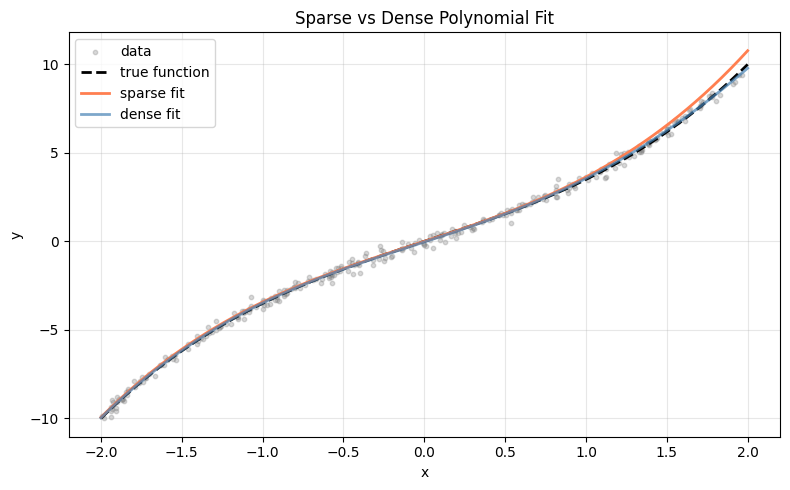

In [7]:
x_plot = numpy.linspace(-2, 2, 300).reshape(-1, 1)
x_plot_aug = numpy.concatenate([
    x_plot,
    AILibs.common.dictionary.dictionary_constant(x_plot),
    AILibs.common.dictionary.dictionary_polynomial(x_plot, order=5)
], axis=1)

y_plot_sp = x_plot_aug @ a_sp_fit
y_plot_dn = x_plot_aug @ a_dn_fit
y_plot_true = 3.0 * x_plot + 0.5 * x_plot**3

plt.figure(figsize=(8, 5))
plt.scatter(x_sp, y_sp, alpha=0.3, s=10, label="data", color="gray")
plt.plot(x_plot, y_plot_true, "k--", linewidth=2, label="true function")
plt.plot(x_plot, y_plot_sp, color="coral", linewidth=2, label="sparse fit")
plt.plot(x_plot, y_plot_dn, color="steelblue", linewidth=2, alpha=0.7, label="dense fit")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Sparse vs Dense Polynomial Fit")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. High-Dimensional Sparse Recovery

50 features, only 5 active — can the sparse algorithm recover them?

In [8]:
n_features_hd = 50
n_active_hd = 5
n_samples_hd = 600

x_hd = rng.standard_normal((n_samples_hd, n_features_hd))

a_true_hd = numpy.zeros((n_features_hd, 1))
active_hd = sorted(rng.choice(n_features_hd, n_active_hd, replace=False))
a_true_hd[active_hd] = rng.standard_normal((n_active_hd, 1)) * 3.0

y_hd = x_hd @ a_true_hd + rng.normal(0, 0.2, (n_samples_hd, 1))

a_sp_hd = AILibs.linear_regression.lr_sparse_fit(x_hd, y_hd)
a_dn_hd = AILibs.linear_regression.lr_fit(x_hd, y_hd)

y_sp_hd = x_hd @ a_sp_hd
y_dn_hd = x_hd @ a_dn_hd

m_sp = AILibs.metrics.regression_evaluation(y_hd, y_sp_hd)
m_dn = AILibs.metrics.regression_evaluation(y_hd, y_dn_hd)

print(f"Active features: {active_hd}")
print(f"Sparse non-zeros: {numpy.count_nonzero(a_sp_hd)} / {n_features_hd}")
print(f"Sparse R²: {m_sp['r2']:.5f}")
print(f"Dense  R²: {m_dn['r2']:.5f}")
print(f"Sparse coeff MSE: {numpy.mean((a_true_hd - a_sp_hd)**2):.6f}")
print(f"Dense  coeff MSE: {numpy.mean((a_true_hd - a_dn_hd)**2):.6f}")

Active features: [np.int64(17), np.int64(23), np.int64(25), np.int64(28), np.int64(45)]
Sparse non-zeros: 50 / 50
Sparse R²: 0.99924
Dense  R²: 0.99924
Sparse coeff MSE: 0.000113
Dense  coeff MSE: 0.000113


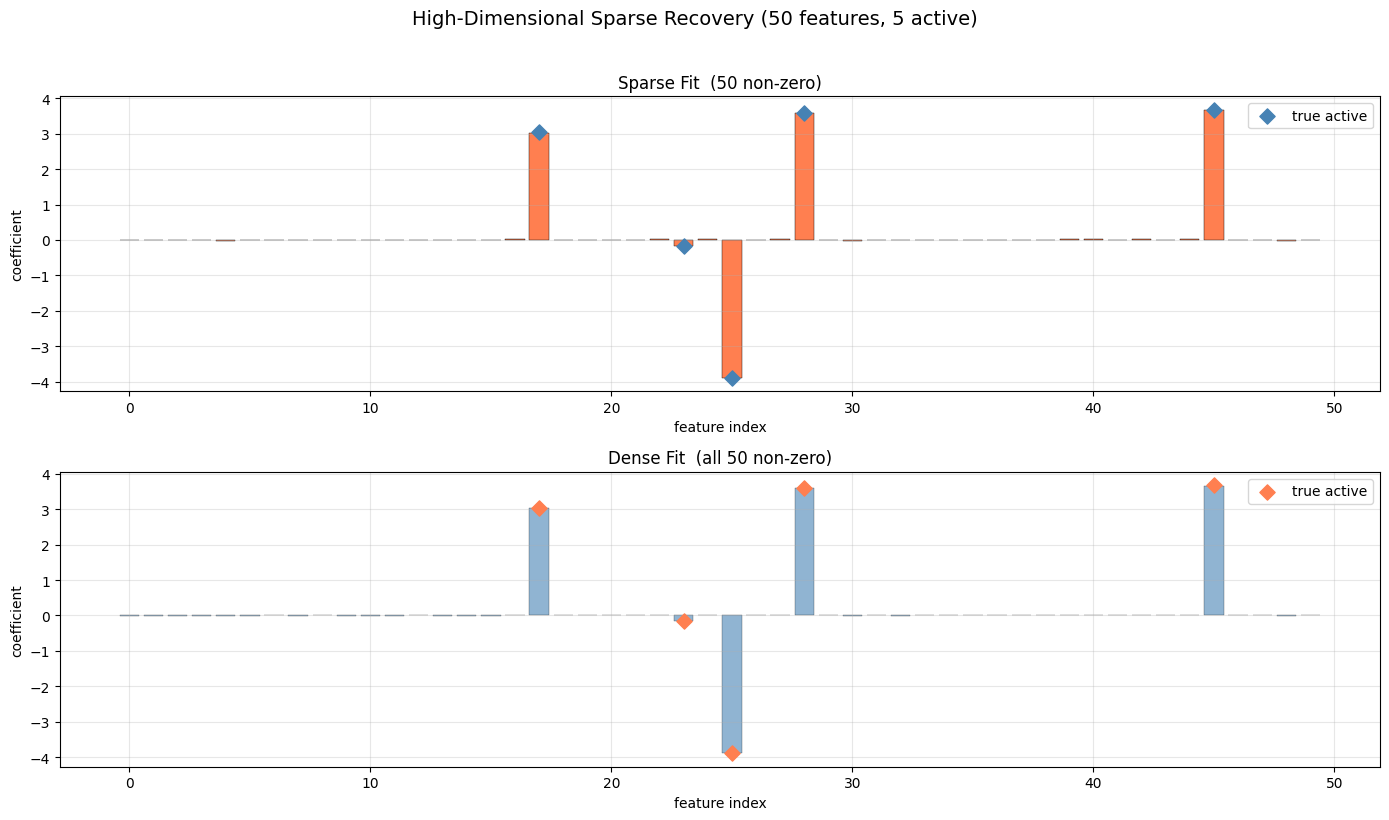

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

idx = numpy.arange(n_features_hd)

# sparse
colors_sp = ["coral" if abs(v) > 0.01 else "lightgray" for v in a_sp_hd.flatten()]
axes[0].bar(idx, a_sp_hd.flatten(), color=colors_sp, edgecolor="black", linewidth=0.3)
axes[0].scatter(active_hd, a_true_hd[active_hd].flatten(), color="steelblue", 
                zorder=5, s=60, marker="D", label="true active")
axes[0].set_title(f"Sparse Fit  ({numpy.count_nonzero(a_sp_hd)} non-zero)")
axes[0].set_xlabel("feature index")
axes[0].set_ylabel("coefficient")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# dense
axes[1].bar(idx, a_dn_hd.flatten(), color="steelblue", alpha=0.6, edgecolor="black", linewidth=0.3)
axes[1].scatter(active_hd, a_true_hd[active_hd].flatten(), color="coral",
                zorder=5, s=60, marker="D", label="true active")
axes[1].set_title(f"Dense Fit  (all {n_features_hd} non-zero)")
axes[1].set_xlabel("feature index")
axes[1].set_ylabel("coefficient")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle("High-Dimensional Sparse Recovery (50 features, 5 active)", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

## 5. Multi-Output Sparse Regression — Coefficient Heatmap

Fit a sparse coefficient matrix $A \in \mathbb{R}^{20 \times 8}$ where 80% of entries are zero.

In [10]:
n_in = 20
n_out = 8
n_samp = 1000
sparsity = 0.8

x_mo = rng.standard_normal((n_samp, n_in))
A_true_mo = rng.standard_normal((n_in, n_out))
mask_mo = rng.random(A_true_mo.shape) < sparsity
A_true_mo[mask_mo] = 0.0

Y_mo = x_mo @ A_true_mo + rng.normal(0, 0.1, (n_samp, n_out))

A_sp_mo = AILibs.linear_regression.lr_sparse_fit(x_mo, Y_mo)
A_dn_mo = AILibs.linear_regression.lr_fit(x_mo, Y_mo)

Y_sp_mo = x_mo @ A_sp_mo
Y_dn_mo = x_mo @ A_dn_mo

m_sp_mo = AILibs.metrics.regression_evaluation(Y_mo, Y_sp_mo)
m_dn_mo = AILibs.metrics.regression_evaluation(Y_mo, Y_dn_mo)

print(f"True non-zeros: {numpy.count_nonzero(A_true_mo)} / {n_in * n_out}")
print(f"Sparse non-zeros: {numpy.count_nonzero(A_sp_mo)} / {n_in * n_out}")
print(f"\nSparse R²: {m_sp_mo['r2']:.5f},  RMSE: {m_sp_mo['rmse']:.5f}")
print(f"Dense  R²: {m_dn_mo['r2']:.5f},  RMSE: {m_dn_mo['rmse']:.5f}")
print(f"\nSparse coeff MSE: {numpy.mean((A_true_mo - A_sp_mo)**2):.6f}")
print(f"Dense  coeff MSE: {numpy.mean((A_true_mo - A_dn_mo)**2):.6f}")

True non-zeros: 34 / 160
Sparse non-zeros: 156 / 160

Sparse R²: 0.99807,  RMSE: 0.09929
Dense  R²: 0.99807,  RMSE: 0.09929

Sparse coeff MSE: 0.000011
Dense  coeff MSE: 0.000011


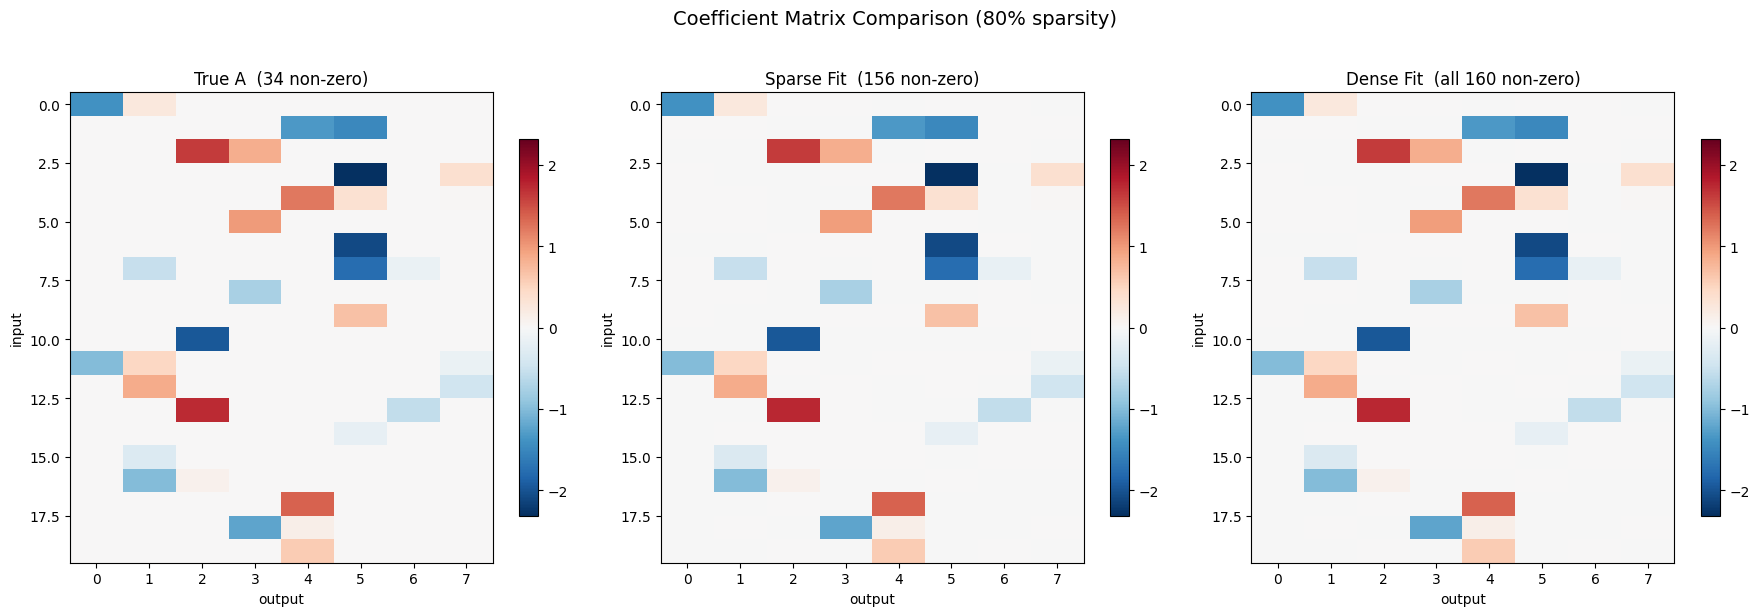

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

vmax = max(numpy.abs(A_true_mo).max(), numpy.abs(A_sp_mo).max(), numpy.abs(A_dn_mo).max())

im0 = axes[0].imshow(A_true_mo, cmap="RdBu_r", vmin=-vmax, vmax=vmax, aspect="auto")
axes[0].set_title(f"True A  ({numpy.count_nonzero(A_true_mo)} non-zero)")
axes[0].set_xlabel("output")
axes[0].set_ylabel("input")
plt.colorbar(im0, ax=axes[0], shrink=0.8)

im1 = axes[1].imshow(A_sp_mo, cmap="RdBu_r", vmin=-vmax, vmax=vmax, aspect="auto")
axes[1].set_title(f"Sparse Fit  ({numpy.count_nonzero(A_sp_mo)} non-zero)")
axes[1].set_xlabel("output")
axes[1].set_ylabel("input")
plt.colorbar(im1, ax=axes[1], shrink=0.8)

im2 = axes[2].imshow(A_dn_mo, cmap="RdBu_r", vmin=-vmax, vmax=vmax, aspect="auto")
axes[2].set_title(f"Dense Fit  (all {n_in * n_out} non-zero)")
axes[2].set_xlabel("output")
axes[2].set_ylabel("input")
plt.colorbar(im2, ax=axes[2], shrink=0.8)

plt.suptitle("Coefficient Matrix Comparison (80% sparsity)", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

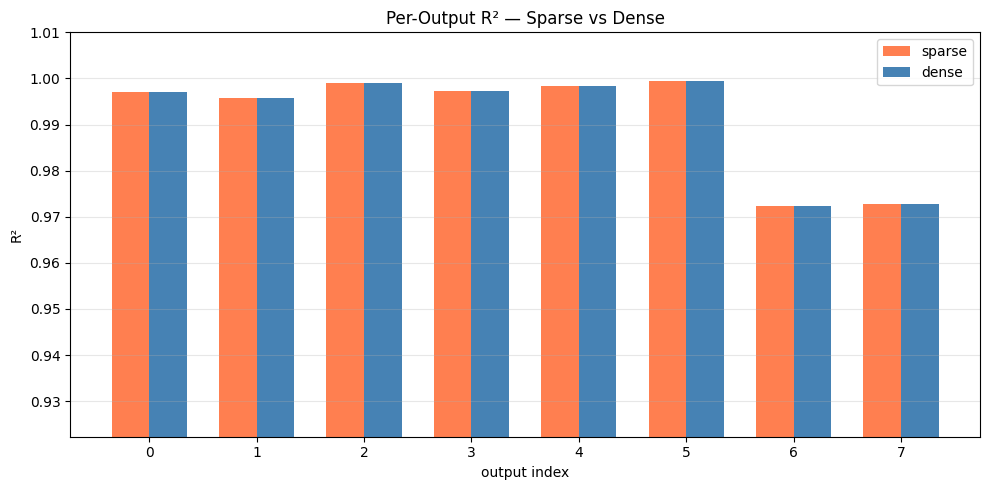

In [12]:
# per-output R² comparison
r2_sparse_per = []
r2_dense_per = []

for i in range(n_out):
    r2_sp_i = AILibs.metrics.regression_evaluation(Y_mo[:, i], Y_sp_mo[:, i])["r2"]
    r2_dn_i = AILibs.metrics.regression_evaluation(Y_mo[:, i], Y_dn_mo[:, i])["r2"]
    r2_sparse_per.append(r2_sp_i)
    r2_dense_per.append(r2_dn_i)

idx_out = numpy.arange(n_out)
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(idx_out - width/2, r2_sparse_per, width, label="sparse", color="coral")
plt.bar(idx_out + width/2, r2_dense_per, width, label="dense", color="steelblue")
plt.xlabel("output index")
plt.ylabel("R²")
plt.title("Per-Output R² — Sparse vs Dense")
plt.legend()
plt.grid(True, alpha=0.3, axis="y")
plt.ylim(min(min(r2_sparse_per), min(r2_dense_per)) - 0.05, 1.01)
plt.tight_layout()
plt.show()